Identify the Most Influential Features: For each principal component, determine the original features with the highest absolute loadings. These are the features that contribute most to each principal component.

Rename the Principal Components: Based on the most influential features, assign meaningful names to each principal component.

Explanation
Load the Dataset and Standardize: Load the Iris dataset and standardize the features.
Perform PCA: Reduce the dimensionality to 2 principal components.
Extract Loadings: Create a DataFrame to hold the loadings (coefficients) of the original features for each principal component.

Identify Influential Features: For each principal component, find the original feature with the highest absolute loading.

Rename Components: Rename the principal components based on the most influential features.
Output Interpretation

Loadings: Shows the contribution of each original feature to each principal component.
Most Influential Features: Lists the most influential original feature for each principal component.

Renamed PCA Components: Shows the new names of the principal components based on the most influential features.

This approach ensures that each principal component is named in a way that reflects the original feature with the most significant contribution, making the components more interpretable and meaningful.

In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE


In [12]:
# Load the dataset
df = pd.read_csv("../../cervical-cancer_csv.csv")

In [13]:
# Drop rows where 'Biopsy' is NaN
df = df.dropna(subset=["Biopsy"])

columns = df.columns
print(f"columns: {columns}")

# Separate features and target variable
X = df.drop('Biopsy', axis=1, inplace=False)
y = df['Biopsy']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Define transformers for numeric and categorical data
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = SimpleImputer(strategy='most_frequent')

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
X = pd.DataFrame(preprocessor.fit_transform(X), columns=X.columns)
df = pd.concat([X, y.reset_index(drop=True)], axis=1)

# Remove duplicate rows
df = df.drop_duplicates()
df.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1, inplace=True)

missing_values = df.isnull().sum()
print(f"Missing entries: {missing_values}")

# Separate features and target variable again after preprocessing
X = df.drop('Biopsy', axis=1, inplace=False)
y = df['Biopsy']

columns: Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')
Missing entries: Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies         

Categorical and continuous columns selection

In [4]:

# Function to identify if a column is categorical
def is_categorical(col, threshold=10):
    unique_values = len(col.unique())
    if unique_values <= threshold:
        return True
    return False

# Identify categorical and continuous columns
categorical_cols = []
continuous_cols = []

for col in X.columns:
    if is_categorical(X[col]):
        categorical_cols.append(col)
    else:
        continuous_cols.append(col)

# Check dtype for additional information
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype == 'bool':
        if col not in categorical_cols:
            categorical_cols.append(col)
    elif X[col].dtype in ['int64', 'float64']:
        if col not in continuous_cols and col not in categorical_cols:
            continuous_cols.append(col)

print(f"Categorical Columns: {categorical_cols}")
print(f"Continuous Columns: {continuous_cols}")


Categorical Columns: ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology']
Continuous Columns: ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)']


 Perform Feature Selection Tests

Categorical Features: Chi-Square Test

Chi-Square Feature Selection Test

In [6]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Apply Chi-Square test
chi_scores, p_values = chi2(X[categorical_cols], y)

chi2_results = pd.DataFrame({
    'Feature': categorical_cols,
    'Chi2 Score': chi_scores,
    'p-value': p_values
})

print("Chi-Square Test Results:")
chi2_results=chi2_results.sort_values(by='Chi2 Score', ascending=False)
print(chi2_results)


Chi-Square Test Results:
                               Feature  Chi2 Score       p-value
23                            Schiller  404.814045  4.931660e-90
22                          Hinselmann  244.179030  4.825279e-55
24                            Citology   77.733404  1.179300e-18
20                              Dx:HPV   21.479063  3.577130e-06
18                           Dx:Cancer   21.479063  3.577130e-06
21                                  Dx   20.444469  6.138670e-06
19                              Dx:CIN   10.739531  1.048709e-03
4                        STDs (number)   10.124247  1.463314e-03
17           STDs: Number of diagnosis    8.336329  3.886004e-03
9                        STDs:syphilis    5.612999  1.782773e-02
3                                 STDs    5.559956  1.837587e-02
7          STDs:vaginal condylomatosis    3.803081  5.115836e-02
16                            STDs:HPV    3.550063  5.954320e-02
12          STDs:molluscum contagiosum    3.424246  6.424557e-02


C:\Users\BoraTech\AppData\Local\Temp\ipykernel_17628\2405003473.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2 Score', y='Feature', data=chi2_results.sort_values(by='Chi2 Score', ascending=False), palette='viridis')


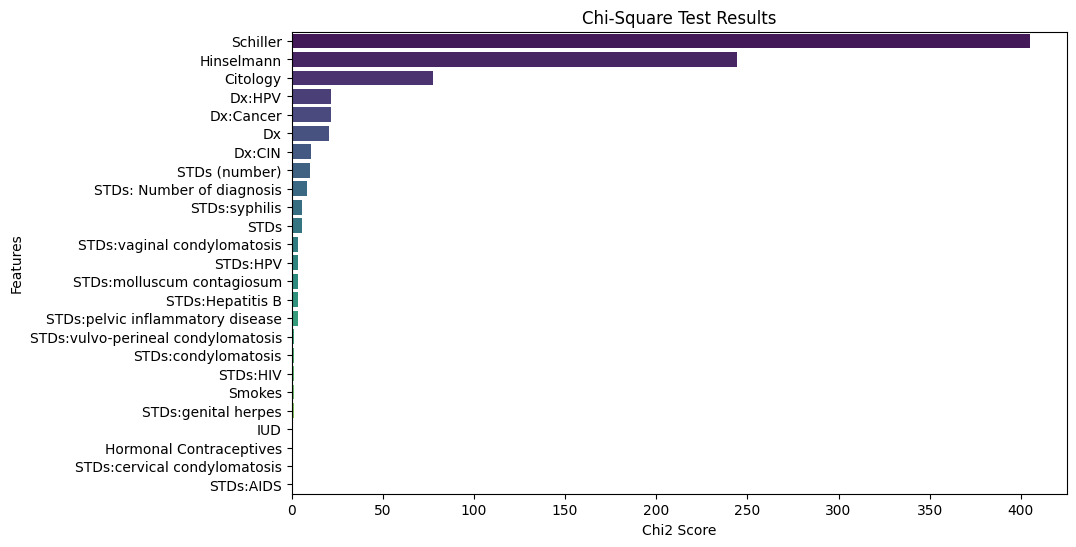

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Chi-Square test results
plt.figure(figsize=(10, 6))
sns.barplot(x='Chi2 Score', y='Feature', data=chi2_results.sort_values(by='Chi2 Score', ascending=False), palette='viridis')
plt.title('Chi-Square Test Results')
plt.xlabel('Chi2 Score')
plt.ylabel('Features')
plt.show()


C:\Users\BoraTech\AppData\Local\Temp\ipykernel_17628\1265663914.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='p-value', y='Feature', data=chi2_results.sort_values(by='p-value', ascending=False), palette='viridis')


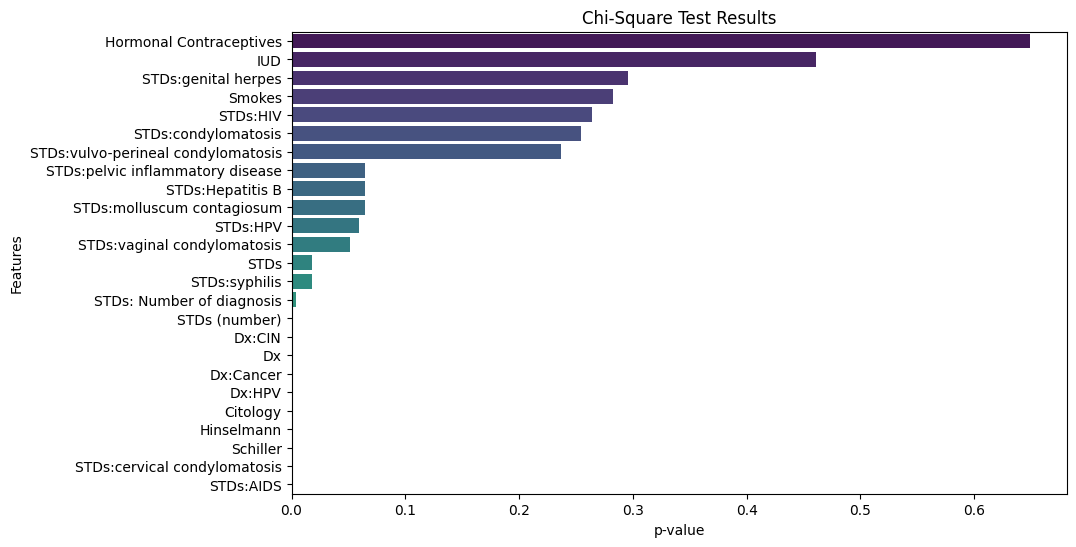

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Chi-Square test results
plt.figure(figsize=(10, 6))
sns.barplot(x='p-value', y='Feature', data=chi2_results.sort_values(by='p-value', ascending=False), palette='viridis')
plt.title('Chi-Square Test Results')
plt.xlabel('p-value')
plt.ylabel('Features')
plt.show()

The Pearson Correlation Test measures the linear correlation between two variables. The result of this test is a coefficient (r) that ranges from -1 to 1, and it is accompanied by a p-value to determine the statistical significance of this correlation.

Interpreting the Pearson Correlation Coefficient (r)
r = 1: Perfect positive correlation. As one variable increases, the other variable increases proportionally.
r = -1: Perfect negative correlation. As one variable increases, the other variable decreases proportionally.
r = 0: No linear correlation. There is no linear relationship between the variables.
Interpreting the p-value
The p-value helps determine the statistical significance of the correlation:

p-value < 0.05: The correlation is statistically significant. There is strong evidence against the null hypothesis (no correlation), so you can conclude that there is a significant linear relationship between the variables.
p-value ≥ 0.05: The correlation is not statistically significant. There is not enough evidence to conclude that there is a significant linear relationship between the variables.

In [7]:
from scipy.stats import pearsonr

# Apply Pearson Correlation test
pearson_results = []
for col in continuous_cols:
    corr, p_value = pearsonr(X[col], y)
    pearson_results.append({'Feature': col, 'Pearson Correlation': corr, 'p-value': p_value})

pearson_df = pd.DataFrame(pearson_results)

print("Pearson Correlation Test Results:")
pearson_df=pearson_df.sort_values(by='Pearson Correlation', ascending=False)

print(pearson_df)


Pearson Correlation Test Results:
                           Feature  Pearson Correlation   p-value
6  Hormonal Contraceptives (years)             0.079738  0.021203
4                   Smokes (years)             0.061448  0.075955
0                              Age             0.054396  0.116261
3               Num of pregnancies             0.044011  0.203920
7                      IUD (years)             0.032216  0.352495
5              Smokes (packs/year)             0.024430  0.480815
2         First sexual intercourse             0.008496  0.806352
1        Number of sexual partners            -0.009584  0.782146


C:\Users\BoraTech\AppData\Local\Temp\ipykernel_17628\3028784389.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pearson Correlation', y='Feature', data=pearson_df.sort_values(by='Pearson Correlation', ascending=False), palette='viridis')


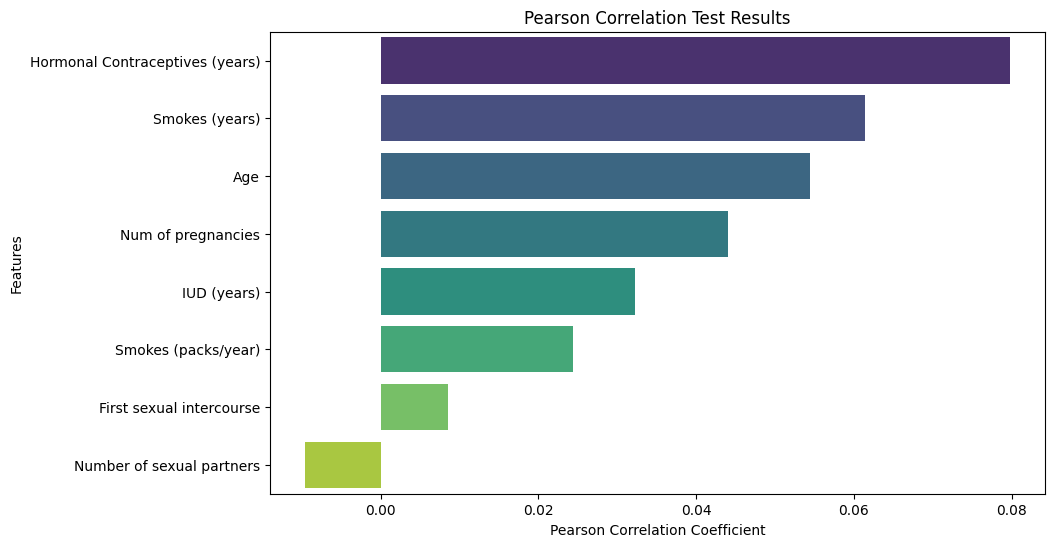

In [38]:
# Plot Pearson Correlation test results
plt.figure(figsize=(10, 6))
sns.barplot(x='Pearson Correlation', y='Feature', data=pearson_df.sort_values(by='Pearson Correlation', ascending=False), palette='viridis')
plt.title('Pearson Correlation Test Results')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Features')
plt.show()


In [9]:
significant_categorical_features = chi2_results[chi2_results['p-value'] < 0.05]['Feature'].tolist()
significant_continuous_features = pearson_df[pearson_df['p-value'] < 0.05]['Feature'].tolist()

selected_features = significant_categorical_features + significant_continuous_features

print("Selected Features:")
print(f"Categorical Features: {significant_categorical_features}")
print(f"Continuous Features: {significant_continuous_features}")
print(f"{selected_features} \n")
print(len(selected_features))


Selected Features:
Categorical Features: ['Schiller', 'Hinselmann', 'Citology', 'Dx:HPV', 'Dx:Cancer', 'Dx', 'Dx:CIN', 'STDs (number)', 'STDs: Number of diagnosis', 'STDs:syphilis', 'STDs']
Continuous Features: ['Hormonal Contraceptives (years)']
['Schiller', 'Hinselmann', 'Citology', 'Dx:HPV', 'Dx:Cancer', 'Dx', 'Dx:CIN', 'STDs (number)', 'STDs: Number of diagnosis', 'STDs:syphilis', 'STDs', 'Hormonal Contraceptives (years)'] 

12


In [41]:

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA to retain 97% of the variance
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_standardized)

# Get the principal components and their loadings
components = pca.components_

# Create a DataFrame to hold the loadings
loadings_df = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=X.columns)
# Display the loadings
print("Loadings:")
print(loadings_df)

# Identify the most influential features for each principal component
influential_features = {}
for i in range(components.shape[0]):
    pc_name = f'PC{i+1}'
    # Get the feature with the highest absolute loading for the current principal component
    most_influential_feature = loadings_df[pc_name].abs().idxmax()
    influential_features[pc_name] = most_influential_feature

# Rename the principal components based on the most influential features
renamed_pca_components = [influential_features[f'PC{i+1}'] for i in range(components.shape[0])]

print("\nMost Influential Features:")
for pc, feature in influential_features.items():
    print(f"{pc}: {feature}")

print("\nRenamed PCA Components:")
print(renamed_pca_components)

# Optionally, create a DataFrame with the renamed components
renamed_df = pd.DataFrame(X_pca, columns=renamed_pca_components)
print("\nPCA Components with Renamed Columns:")
print(renamed_df.head())

# Create a mapping from original data to standardized data
original_to_standardized = pd.DataFrame({
    'Original': X.values.flatten(),
    'Standardized': X_standardized.flatten()
})

print("\nMapping from Original to Standardized Values:")
print(original_to_standardized.head())

# Optionally, map principal components back to the standardized feature space
X_pca_inverse_transformed = pca.inverse_transform(X_pca)
X_standardized_mapped_back = pd.DataFrame(X_pca_inverse_transformed, columns=X.columns)

print("\nMapped Back Standardized DataFrame:")
print(X_standardized_mapped_back.head())

model = RandomForestClassifier(random_state=42)
model.fit(X_pca, y)


Loadings:
                                         PC1           PC2           PC3  \
Age                                -0.047762  1.136634e-01  2.111005e-01   
Number of sexual partners           0.007388  8.391224e-02  4.711527e-02   
First sexual intercourse           -0.037054  1.007230e-02  2.815629e-02   
Num of pregnancies                 -0.024357  1.018640e-01  1.512010e-01   
Smokes                              0.026098  1.823808e-01  6.129264e-02   
Smokes (years)                      0.014505  2.047206e-01  1.334386e-01   
Smokes (packs/year)                 0.002455  1.578544e-01  1.399124e-01   
Hormonal Contraceptives            -0.035856  8.166624e-03  6.239007e-02   
Hormonal Contraceptives (years)     0.006449  4.053682e-02  1.286186e-01   
IUD                                 0.132526  1.362860e-02  2.125993e-01   
IUD (years)                         0.009641  5.513554e-02  1.730496e-01   
STDs                                0.241711  3.302918e-01 -1.265181e-01   
ST

RandomForestClassifier(random_state=42)

COMBINE FEATURE SELECTION AND PCA

C:\Users\BoraTech\AppData\Local\Temp\ipykernel_22080\681380513.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2 Score', y='Feature', data=chi2_df, palette='viridis')


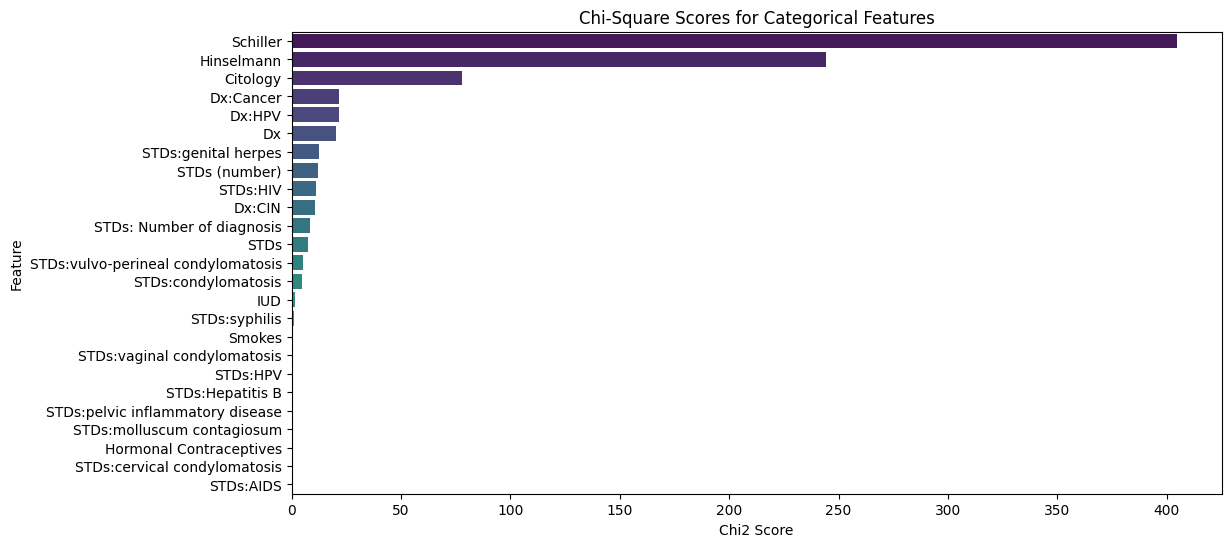

C:\Users\BoraTech\AppData\Local\Temp\ipykernel_22080\681380513.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-Score', y='Feature', data=f_df, palette='viridis')


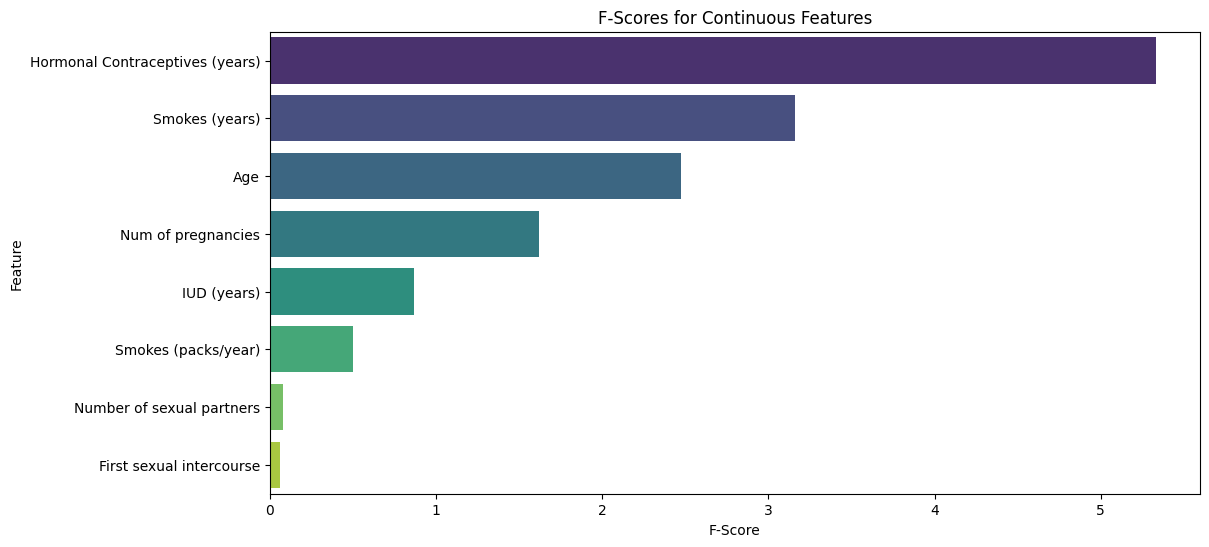

Continuous Features: ['Hormonal Contraceptives (years)', 'Smokes (years)']
Categorical Features: ['Schiller', 'Hinselmann', 'Citology', 'Dx:Cancer', 'Dx:HPV', 'Dx', 'STDs:genital herpes', 'STDs (number)', 'STDs:HIV', 'Dx:CIN', 'STDs: Number of diagnosis', 'STDs', 'STDs:vulvo-perineal condylomatosis', 'STDs:condylomatosis']
Total Features: 16


ValueError: could not convert string to float: 'STDs:genital herpes'

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

chi2_scores, chi2_pvalues = chi2(X[categorical_cols], y)
f_scores, f_pvalues = f_classif(X[continuous_cols], y)

# Create DataFrame for feature scores
chi2_df = pd.DataFrame({
    'Feature': categorical_cols,
    'Chi2 Score': chi2_scores,
    'P-value': chi2_pvalues
}).sort_values(by='Chi2 Score', ascending=False)

f_df = pd.DataFrame({
    'Feature': continuous_cols,
    'F-Score': f_scores,
    'P-value': f_pvalues
}).sort_values(by='F-Score', ascending=False)

# Plot Chi-Square scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2 Score', y='Feature', data=chi2_df, palette='viridis')
plt.title('Chi-Square Scores for Categorical Features')
plt.show()

# Plot F-Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='F-Score', y='Feature', data=f_df, palette='viridis')
plt.title('F-Scores for Continuous Features')
plt.show()

significant_continuous_features=list(f_df[f_df['P-value'] < 0.1]['Feature'])
significant_categorical_features=list(chi2_df[chi2_df['P-value'] < 0.1]['Feature'])
# Combine selected features
selected_features = significant_categorical_features + significant_continuous_features
# X_selected = X[selected_features]
X_selected = list(set(selected_features))
print(f"Continuous Features: {significant_continuous_features}")
print(f"Categorical Features: {significant_categorical_features}")
print(f"Total Features: {len(X_selected)}")

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_selected)

# Apply PCA to retain 97% of the variance
pca = PCA(n_components=0.97)
X_pca = pca.fit_transform(X_standardized)

# Get the principal components and their loadings
components = pca.components_

# Create a DataFrame to hold the loadings
loadings_df = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=X_selected.columns)
print("Loadings:")
print(loadings_df)

# Identify the most influential features for each principal component
influential_features = {}
for i in range(components.shape[0]):
    pc_name = f'PC{i+1}'
    most_influential_feature = loadings_df[pc_name].abs().idxmax()
    influential_features[pc_name] = most_influential_feature

# Rename the principal components based on the most influential features
renamed_pca_components = [influential_features[f'PC{i+1}'] for i in range(components.shape[0])]

print("\nMost Influential Features:")
for pc, feature in influential_features.items():
    print(f"{pc}: {feature}")

print("\nRenamed PCA Components:")
print(renamed_pca_components)

# Create a DataFrame with the renamed components
renamed_df = pd.DataFrame(X_pca, columns=renamed_pca_components)
print("\nPCA Components with Renamed Columns:")
print(renamed_df.head())

Implementation of ADASYN, MWMOTE, and SMOTETomek for Data Balancing in ML

In [51]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import NearMiss

# Note: MWMOTE is not directly available in imbalanced-learn. We will use an alternative ensemble method.


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [59]:
adasyn = ADASYN(random_state=42)
X_res_ada, y_res_ada = adasyn.fit_resample(X_train, y_train)


In [53]:
smote_tomek = SMOTETomek(random_state=42)
X_res_smote, y_res_smote = smote_tomek.fit_resample(X_train, y_train)

In [54]:
smote_tomek = SMOTETomek(random_state=42)
X_res_smote, y_res_smote = smote_tomek.fit_resample(X_train, y_train)


In [55]:
brf = BalancedRandomForestClassifier(random_state=42)
brf.fit(X_train, y_train)


d:\Projects\Python\ML\cervical\venv\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
d:\Projects\Python\ML\cervical\venv\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
d:\Projects\Python\ML\cervical\venv\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

BalancedRandomForestClassifier(random_state=42)

In [56]:
def train_evaluate(X_train, y_train, X_test, y_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return accuracy, precision, recall


In [60]:
accuracy, precision, recall = train_evaluate(X_train, y_train, X_test, y_test)
print("Original Data: Accuracy = {:.2f}, Precision = {:.2f}, Recall = {:.2f}".format(accuracy, precision, recall))


Original Data: Accuracy = 0.95, Precision = 0.60, Recall = 0.75


d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [61]:
accuracy, precision, recall = train_evaluate(X_res_ada, y_res_ada, X_test, y_test)
print("ADASYN: Accuracy = {:.2f}, Precision = {:.2f}, Recall = {:.2f}".format(accuracy, precision, recall))


ADASYN: Accuracy = 0.95, Precision = 0.59, Recall = 0.81


d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [62]:
accuracy, precision, recall = train_evaluate(X_res_smote, y_res_smote, X_test, y_test)
print("SMOTETomek: Accuracy = {:.2f}, Precision = {:.2f}, Recall = {:.2f}".format(accuracy, precision, recall))


SMOTETomek: Accuracy = 0.95, Precision = 0.57, Recall = 0.75


d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [63]:
y_pred_brf = brf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_brf)
precision = precision_score(y_test, y_pred_brf)
recall = recall_score(y_test, y_pred_brf)
print("Balanced Random Forest: Accuracy = {:.2f}, Precision = {:.2f}, Recall = {:.2f}".format(accuracy, precision, recall))


Balanced Random Forest: Accuracy = 0.92, Precision = 0.42, Recall = 0.88


([<matplotlib.axis.XTick at 0x24590fba940>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

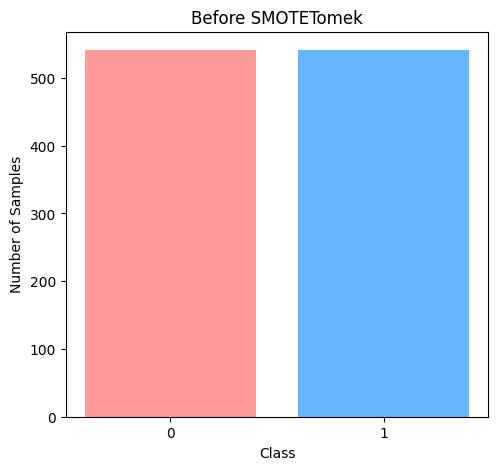

In [66]:
from collections import Counter

counter_before = Counter(y_res_smote)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(counter_before.keys(), counter_before.values(), color=['#ff9999','#66b3ff'])
plt.title('Before SMOTETomek')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks([0, 1])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


def predict_manual_input(input_data):
    # Create DataFrame for the manual input
    input_df = pd.DataFrame([input_data], columns=X.columns)
    
    # Apply the same preprocessing steps
    input_df_processed = pd.DataFrame(preprocessor.transform(input_df), columns=X.columns)
    
    # Standardize the input data
    input_standardized = scaler.transform(input_df_processed)
    
    # Apply PCA transformation
    input_pca = pca.transform(input_standardized)
    
    # Make prediction using the trained model
    prediction = model.predict(input_pca)
    return prediction

manual_input = {
    'Age': 45,
    'Number of sexual partners': 4,
    'First sexual intercourse': 16,
    'Num of pregnancies': 2,
    'Smokes': 0,
    'Hormonal Contraceptives': 0,
    'IUD': 0,
    'STDs: Number of diagnosis': 1,
    'STDs: Time since first diagnosis': 3,
    'STDs: Time since last diagnosis': 1
}

# Make prediction
prediction = predict_manual_input(manual_input)
print("Predicted Biopsy Result:", prediction[0])

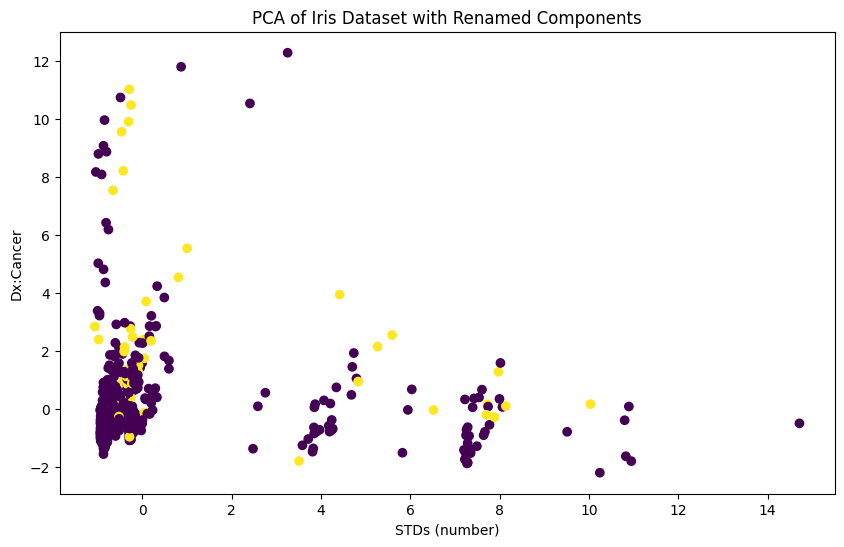

In [12]:
# Visualize the renamed components
plt.figure(figsize=(10, 6))
plt.scatter(renamed_df[renamed_pca_components[0]], renamed_df[renamed_pca_components[1]], c=y)
plt.xlabel(renamed_pca_components[0])
plt.ylabel(renamed_pca_components[1])
plt.title('PCA of Iris Dataset with Renamed Components')
plt.show()


RFE

In [17]:
# Initialize the XGBoost model
model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)


In [18]:
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit RFE
rfe = rfe.fit(X, y)

# Check the selected features
print(f'Selected Features: {X.columns[rfe.support_]}')

d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:13:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:13:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:13:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Project

Selected Features: Index(['Age', 'Num of pregnancies', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'STDs:pelvic inflammatory disease',
       'STDs:genital herpes', 'Dx:CIN', 'Dx', 'Hinselmann', 'Schiller'],
      dtype='object')


d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Projects\Python\ML\cervical\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
